### IMPORTING NECESSARY LIBRARIES 

1. DATA HANDLING 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

2. DATA PRE PROCESSING

In [2]:
import keras
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing import text, sequence
# from keras_preprocessing.sequence import pad_sequences

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences

3. MODEL DEVELOPMENT 

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Conv1D, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.losses import binary_crossentropy
from keras.optimizers import Adam


4. SAVING THE MODEL 

In [5]:
import joblib

### DATASET

In [6]:
file_path = "/Users/lalitaneeharikavajjhala/Desktop/Research credits /Data/norm_dataset.csv"
df = pd.read_csv(file_path)

In [7]:
pd.set_option('display.max_colwidth', None)
df.head()

,text,norm
0,"Client agrees to pay to Company the sum of $5,000 (the “Contract Price”) to design and develop a website for Client (the “Client Website”) in accordance with the accompanying Scope of Work, attached to this Agreement as Exhibit A.",1
1,Company will use its best efforts to deliver the Client Website in the time frame specified in the Scope of Work.,1
2,"All written content submitted by Client for use in the Client Website must be typewritten, proofread and delivered to Company in the body of an email message or as a Microsoft Word electronic document or plaint text electronic document.",1
3,It is Client’s sole responsibility to check the accuracy of the written content and correct any errors prior to submission for final publication.,1
4,Client further agrees that Company may use and display the graphics and other web design elements of Client’s website as examples of Company website design and development work.,1


In [8]:
# Removing duplicates
df.drop_duplicates(keep='first', inplace=True)

In [9]:
# Assigning norms to target variable. Values already numeric
y = df['norm']
y

0      1
1      1
2      1
3      1
4      1
      ..
361    1
362    1
363    1
364    1
365    1
Name: norm, Length: 360, dtype: int64

In [10]:
# Standard keras pre-processing
maxlen = 200 # Highest word count is 555 and mean is 43
max_words = 2000
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(df.text)
# Basically, this code prepares text data for further processing by setting limits on sequence length, tokenizing the text, and building a vocabulary of words based on their frequency in the data

In [11]:
# Functions to transform text to feature_vectors 
def get_features(text_series):
    sequences = tokenizer.texts_to_sequences(text_series)
    return pad_sequences(sequences, maxlen=maxlen)
# Feature selection 
# The text is converted into a sequesnce of integers  representing the index of each word in the tokenizer's word index
# The sequence of integers is also padded (ie, they all have the same length) by adding zeros in the beginnning and keeping the length lesser than the max_len, set to 200 earlier 
# Finally the padded sequences are returned which are now feature vectors representing input text data 

In [12]:
# Calling function to create features 'X'
X = get_features(df.text)

print(X.shape, y.shape)

(360, 200) (360,)


In [13]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0, shuffle=True, stratify=y)

In [14]:
# law2vec 100 dimensional word embeddings
from numpy import array, asarray, zeros
vocab_size = len(tokenizer.word_index) + 1

embeddings_dictionary = dict()

law2vec_file = open("/Users/lalitaneeharikavajjhala/Desktop/Research credits /Data/Law2Vec.100d.txt", encoding="utf8")
# We're calculating the vocabulary size by getting the length of the word index created by the tokenizer
# The +1 is for accomodating any out of vocabulary words that might occour 

In [15]:
# Parsing each line 
for line in law2vec_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
law2vec_file.close()
# Overall, this code parses each line of the Law2Vec file, extracts the word and its corresponding vector, and stores them in a dictionary

In [16]:
# Each row corresponds to a word with its 100 dimensional word vector
embedding_matrix = zeros((vocab_size, 100))
# This matrix is the same as that in the previous file

In [17]:
# tokenizer.word_index is a list of (word, id) tuples
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
# Here we are populating the embedding_matrix with word vectors from the Law2Vec embeddings for words that are present in the tokenizer's word index
# If an embedding is not found for a word, its corresponding row in the matrix remains filled with zeros
# This matrix becomes the pre trained weights for the cross validation 

In [18]:
from sklearn.model_selection import KFold

In [19]:
# Converting X and y to NumPy arrays if they are not already
X = np.array(X)
y = np.array(y)
# These are the input features (X) and target labels (y)

# Defining the number of folds for cross-validation
k = 5

# Creating a KFold object
kf = KFold(n_splits=k, shuffle=True, random_state=0) #indicating that this object will split the data into k (here 5) folds 

# Initializing lists to store evaluation metrics for each fold
accuracy_scores = []
loss_scores = []
train_losses = []
val_losses = []

# Defining callbacks
callbacks = [
    ReduceLROnPlateau(), # The learning rate is reduced when a metric has stopped improving 
    EarlyStopping(patience=4),   # ie training is stopped when a monitored metric has stopped improving, so overfitting is not caused 
]


In [20]:
# Iterating over the folds
for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    print(f"Fold {fold}")  # For every fold, the fold number is printed 

    # Splitting the data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    
    # Building and compile the model (same code as before)
    filter_length = 300
    num_classes = 1 
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.1))
    model.add(Conv1D(filter_length, kernel_size=8, activation='relu'))
    model.add(GlobalMaxPool1D())
    model.add(Flatten())
    model.add(Dense(num_classes))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Fitting the model on the training data for the current fold
    history = model.fit(X_train_fold, y_train_fold,
                        epochs=20,
                        batch_size=32,
                        callbacks=callbacks,
                        verbose=0)
     # Evaluating the model on the validation data for the current fold
    #_, accuracy = model.evaluate(X_val_fold, y_val_fold)
    #loss, _ = model.evaluate(X_val_fold, y_val_fold)
    train_loss, train_accuracy = model.evaluate(X_train_fold, y_train_fold, verbose=0)
    train_losses.append(train_loss)

    # Evaluating model on the validation data for the current fold
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    val_losses.append(val_loss)

    # Appending the evaluation scores to the lists
    accuracy_scores.append(val_accuracy)
    loss_scores.append(val_loss)
    print()


Fold 1

Fold 2

Fold 3

Fold 4

Fold 5



In [21]:
# Printing the training and validation loss for each fold
for fold in range(k):
    print(f"Fold {fold+1} - Train Loss: {train_losses[fold]:.4f} - Val Loss: {val_losses[fold]:.4f}")

# Calculating and print the mean evaluation scores across all folds
print("Mean Accuracy:", np.mean(accuracy_scores))
print("Mean Loss:", np.mean(loss_scores))

# After the cross-validation, proceeding with testing on the separate test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)                    

Fold 1 - Train Loss: 0.0098 - Val Loss: 0.2664
Fold 2 - Train Loss: 0.0097 - Val Loss: 0.2320
Fold 3 - Train Loss: 0.0150 - Val Loss: 0.3073
Fold 4 - Train Loss: 0.0085 - Val Loss: 0.3400
Fold 5 - Train Loss: 0.0126 - Val Loss: 0.2439
Mean Accuracy: 0.8861111164093017
Mean Loss: 0.27791416049003603
3/3 [==============================] - 0s 6ms/step - loss: 0.0744 - accuracy: 0.9722
Test Accuracy: 0.9722222089767456
Test Loss: 0.0743984580039978


### EVALUATING THE MODELS 

In [22]:
# Evaluation metrics
metrics = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))

3/3 [==============================] - 0s 6ms/step
loss: 0.0743984580039978
accuracy: 0.9722222089767456


In [23]:
# Calculating precision, recall, and F1 scores
from sklearn.metrics import precision_score, recall_score, f1_score

# Converting y_pred to binary labels using a threshold of 0.5
binary_pred = (y_pred > 0.5).astype(int)

# Calculating precision, recall, and F1 score
precision = precision_score(y_test, binary_pred)
recall = recall_score(y_test, binary_pred)
f1 = f1_score(y_test, binary_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.9714285714285714
Recall: 0.9714285714285714
F1 Score: 0.9714285714285714


### PREDICTION

In [24]:
# Prediction
x = ["Each Party shall return to the other all of the other’s Confidential Information and any other material, information or samples relating to the Product which have been provided or made available to the other and shall not retain any copies and the Parties further agree not to make any further use of each other’s Confidential Information or any other information, data or samples relating to the Product provided or made available by the other Party, except as necessary to comply with its statutory, regulatory or licensing obligations; provided, however, that Kitov may retain such material, information and/or samples relating to the Product as may be necessary for Kitov to continue to sell the Product as permitted by Section ​5.4.4 below, following which, Kitov shall refrain from making any further use of Dexcel’s Confidential Information or any other information, data or samples and shall return any remaining Confidential Information and material, information or samples relating to the Product."]
xt = get_features(x)
prediction = model.predict(xt)
probas = (prediction > 0.5).astype(int)

if probas == [1]:
    tag = 'Norm'
else:
    tag = 'Non-norm'

print(prediction)
print(probas)
print(tag)

1/1 [==============================] - 0s 8ms/step
[[0.9466141]]
[[1]]
Norm


### SAVING THE MODELS

In [25]:
# Saving the tokenizer
joblib.dump(tokenizer, "/Users/lalitaneeharikavajjhala/Desktop/Research credits /Models/BinaryLabelTokenizer.pkl")

['/Users/lalitaneeharikavajjhala/Desktop/Research credits /Models/BinaryLabelTokenizer.pkl']

In [26]:
# Saving the model
joblib.dump(model, "/Users/lalitaneeharikavajjhala/Desktop/Research credits /Models/BinaryLabelModel_CNN.pkl")

['/Users/lalitaneeharikavajjhala/Desktop/Research credits /Models/BinaryLabelModel_CNN.pkl']

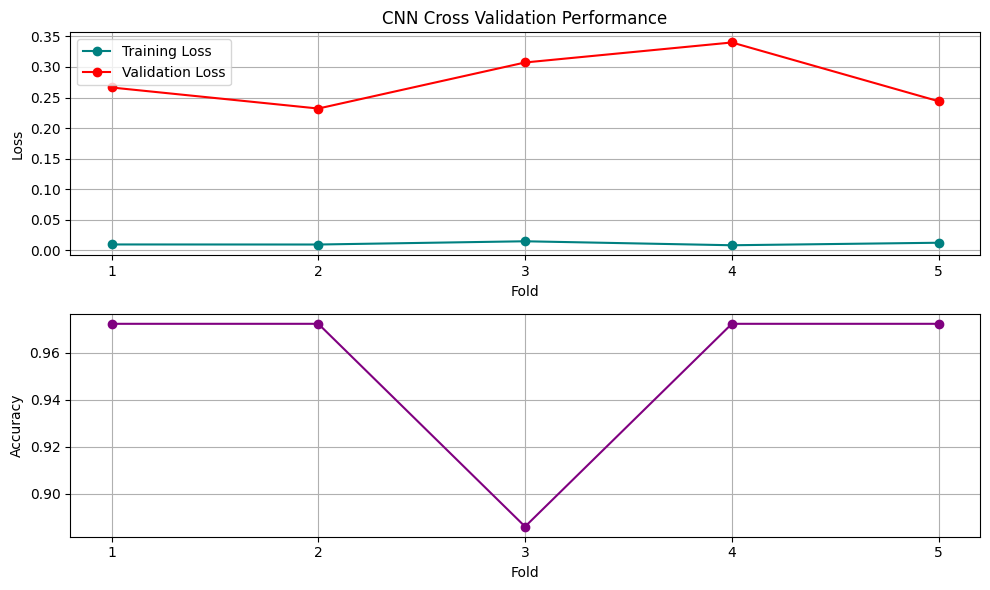

In [7]:
import matplotlib.pyplot as plt

# Define the training and validation losses for each fold
train_losses = [0.0098, 0.0097, 0.0150, 0.0085, 0.0126]
val_losses = [0.2664, 0.2320, 0.3073, 0.3400, 0.2439]
accuracies = [0.9722, 0.9722, 0.8861, 0.9722, 0.9722]  # Add accuracies for each fold

# Plot the training and validation losses
plt.figure(figsize=(10, 6))

# Plot loss
plt.subplot(2, 1, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o', color="teal")
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o', color="red")
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('CNN Cross Validation Performance')
plt.xticks(range(1, len(train_losses) + 1))
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(2, 1, 2)
plt.plot(range(1, len(accuracies) + 1), accuracies, label='Accuracy', marker='o', color='purple')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(accuracies) + 1))
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()
